In [1]:
import logging
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import jax
from math import log, exp, sqrt


from bmws import Observation, sim_and_fit, sim_wf
from bmws.betamix import forward, BetaMixture
from bmws.data import Dataset
from bmws.estimate import empirical_bayes, estimate, jittable_estimate, _beta_pdf
from bmws.sim import sim_admix
rng = np.random.default_rng()

In [2]:
#This block is just reading in the data, sorry it's a bit gross 

#Load EAS data
admixture_proportions=pd.read_csv("admixture_proportions.txt", sep="\t")
admixture_proportions["generation"]=[int(x) for x in round(admixture_proportions["Date"]/30)]
admixture_proportions=admixture_proportions[(admixture_proportions['Date'] <=10000)]

#merge allele counts 
counts=pd.read_csv("snp_acs.raw", sep="\t")
data=pd.merge(admixture_proportions, counts, on="IID")

#Spread present-day samples randomly over last 10 generations, for computational efficiency. 
for i in range(data.shape[0]):
    if data.iloc[i, data.columns.get_loc('generation')]==0:
        data.iloc[i, data.columns.get_loc('generation')]=rng.choice(10)

#Parameters for data matrices
T=max(data["generation"])+1
N=max(data["generation"].value_counts().values)

#Which SNP to look at
snp="rs7925299_C(/G)"

#Create data matrices
obs = np.zeros([T, N, 2], dtype=int)
samples = np.zeros([T, N], dtype=int)
#thetas = np.zeros([T, N, 3], dtype=float)
thetas = rng.dirichlet(np.ones(3), [T, N])

# New data format

Create a list of "records" and then call `data = Dataset.from_records()`. Each record is of the form:

    rec = {
        't': t,  # time of observation (gens before present)
        'theta': theta  # [K] admixture proportions,
        'obs': (n, d)   # tuple: n = # of observed alleles, d = # of derived alleles.
    }
    
(For diploid data, $n=2$, while for pseuodhaploid data $n=1$)

In [3]:
#Fill in data matrices (in simplest way possible) - generation, N
records = []

for gen, count in data["generation"].value_counts().items():
    this_data=data[data["generation"]==gen]
    M=this_data.shape[0]
    for i in range(M):
        if not this_data[snp].isna().iloc[i]:
            rec = {'t': gen}
            rec['obs'] = (1, int(this_data[snp].values[i] / 2))
            rec['theta'] = [this_data["North"].iloc[i], 
                            this_data["South"].iloc[i]]
            rec['theta'].append(1 - sum(rec['theta']))
            records.append(rec)

In [4]:
data = Dataset.from_records(records)

## New objective function
Additional regularization terms have been added. The estimand $\mathbf{s}\in\mathbb{R}^{T\times K}$ is now a matrix with $T$ rows (time points) and $K$ columns/populations. The new objective function is:

$$f(\mathbf{s}) = -\mathrm{loglik}(\text{data}\mid N_e,\mathbf{s}) 
+ \alpha \sum_k \sum_{t=2}^T (s_{k,t} - s_{k,t-1})^2 
+ \beta \sum_t \sum_{k_1,k_2 \in [K]} (s_{k_1,t} - s_{k_2,t})^2 
+ \gamma \Vert \mathbf{s} \Vert_*$$

so:

- $\alpha$ controls smoothness "across time" of the $s_{kt}$ for each population $k$
- $\beta$ controls smoothness "between groups"
- $\gamma$ penalizes the rank of the matrix $s$, setting $\gamma\to\infty$ makes each estimated $s$ become a scalar multiple of the other.

$\beta$ and $\gamma$ sort of aim at the same goal, we'll need to experiment to see which makes more sense.

In [12]:
#Run analysis - no longer fails!
em_iterations=1
M=100
Ne=np.full([data.T, data.K], 1e4)
Ne_fit=Ne
s = np.zeros([data.T, data.K])
ab = np.ones([2, data.K]) + 1e-4
estimate_kwargs={"alpha": 0, "beta": 0, "gamma": 1e-4}

with jax.debug_nans(True):
    for i in range(em_iterations):
        logger.info("EM iteration %d", i)
        ab, prior = empirical_bayes(ab0=ab, s=s, data=data, Ne=Ne, M=M)
        logger.info("ab: %s", ab)
        s = estimate(data=data, Ne=Ne_fit, prior=prior, **estimate_kwargs)
        logger.info("s: %s", s)

betas, _ = forward(s, Ne, data, prior)

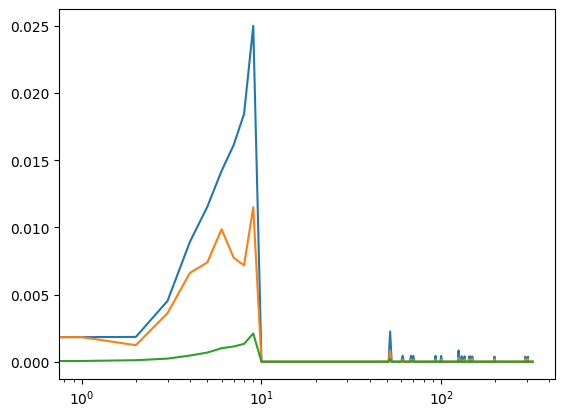

In [13]:
plt.plot(s[:, 0], color="tab:blue", alpha=1)
plt.plot(s[:, 1], color="tab:orange", alpha=1)
plt.plot(s[:, 2], color="tab:green", alpha=1)
plt.xscale('log')